In [73]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import seaborn as sns

In [2]:
import os
import numpy as np
import random
import pandas as pd

class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [3]:
class PhenotypingReader(Reader):
    def __init__(self, dataset_dir, listfile=None):
        """ Reader for phenotype classification task.

        :param dataset_dir: Directory where timeseries files are stored.
        :param listfile:    Path to a listfile. If this parameter is left `None` then
                            `dataset_dir/listfile.csv` will be used.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(mas[0], float(mas[1]), list(map(int, mas[2:]))) for mas in self._data]

    def _read_timeseries(self, ts_filename):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : array of ints
                Phenotype labels.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._data[index][1]
        y = self._data[index][2]
        (X, header) = self._read_timeseries(name)

        return {"X": X,
                "t": t,
                "y": y,
                "header": header,
                "name": name}

In [4]:
dataset_dir = "C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\phenotyping"
root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [5]:
train_reader = PhenotypingReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                         listfile=os.path.join(dataset_dir, 'train','listfile.csv'))


test_reader = PhenotypingReader(dataset_dir=os.path.join(dataset_dir, 'test'),
                                       listfile=os.path.join(dataset_dir, 'test','listfile.csv'))

In [6]:
global_category_mapping = {
  'Glascow coma scale eye opening': {'': 0,
  'To Pain': 1,
  'None': 2,
  'Spontaneously': 3,
  'To Speech': 4,
  '4 Spontaneously': 5,
  '1 No Response': 6,
  '2 To pain': 7,
  '3 To speech': 8},
 'Glascow coma scale motor response': {'': 0,
  'Localizes Pain': 1,
  '3 Abnorm flexion': 2,
  'Abnormal extension': 3,
  '5 Localizes Pain': 4,
  '6 Obeys Commands': 5,
  'Flex-withdraws': 6,
  '2 Abnorm extensn': 7,
  'Obeys Commands': 8,
  'Abnormal Flexion': 9,
  'No response': 10,
  '4 Flex-withdraws': 11,
  '1 No Response': 12},
 'Glascow coma scale verbal response': {'': 0,
  'Inappropriate Words': 1,
  'Incomprehensible sounds': 2,
  'Oriented': 3,
  '2 Incomp sounds': 4,
  '4 Confused': 5,
  'No Response-ETT': 6,
  '3 Inapprop words': 7,
  'Confused': 8,
  'No Response': 9,
  '1.0 ET/Trach': 10,
  '5 Oriented': 11,
  '1 No Response': 12}}

In [7]:
import numpy as np
import pandas as pd

TIME_WINDOWS = [(0, 6), (0, 12), (0, '25%'), (0, '50%'), (0, '100%')]

CHANNELS = {
    'Diastolic blood pressure': 'numerical',
    'Fraction inspired oxygen': 'numerical',
    'Glascow coma scale eye opening': 'categorical',
    'Glascow coma scale motor response': 'categorical',
    'Glascow coma scale total': 'numerical',
    'Glascow coma scale verbal response': 'categorical',
    'Glucose': 'numerical',
    'Heart Rate': 'numerical',
    'Mean blood pressure': 'numerical',
    'Oxygen saturation': 'numerical',
    'Respiratory rate': 'numerical',
    'Systolic blood pressure': 'numerical',
    'Temperature': 'numerical',
    'Weight': 'numerical'
}

admission_mapping = {'UNKNOWN': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'URGENT': 3}
dbsource_mapping = {'carevue': 1, 'metavision': 2, 'both': 3}
icu_unit_mapping = {'MICU': 1, 'CCU': 2, 'TSICU': 3, 'SICU': 4, 'CSRU': 5}

def extract_features_from_reader(train_reader, index, root):
     # Read the example data from the reader
    example_data = train_reader.read_example(index)
    ts_data = pd.DataFrame(data=example_data['X'], columns=example_data['header'])
    
#     Replace empty strings with NaN
#     ts_data = ts_data.replace('', np.nan)
    
#     # Forward fill to carry forward the last known value
#     ts_data = ts_data.fillna(method='ffill')
    
#     # Backward fill to fill any remaining NaNs
#     ts_data = ts_data.fillna(method='bfill')
    
#     # If there are still any NaNs, fill them with 0
#     ts_data = ts_data.fillna(0)
#     ts_data = ts_data.apply(pd.to_numeric, errors='coerce')
    ts_data['Hours'] = ts_data['Hours'].astype(float)
    
    all_features = []
    all_categorical_features = []
    labels = []
    for start_hour, end_hour in TIME_WINDOWS:
        # Determine the end_hour for percentage-based windows
        if isinstance(start_hour, str):
            start_hour = ts_data['Hours'].quantile(0.75)
        if isinstance(end_hour, str):
            end_hour = ts_data['Hours'].max()
#             total_hours = ts_data['Hours'].max()
#             end_hour = total_hours * float(end_hour.strip('%')) / 100.0
        

        
        # Filter the data for the current time window
        ts_window_data = ts_data[(ts_data['Hours'] >= start_hour) & (ts_data['Hours'] <= end_hour)]
        ts_window_data_num = ts_window_data.apply(pd.to_numeric, errors='coerce')
        features = []
        for channel, channel_type in CHANNELS.items():
            if channel_type == 'numerical'and channel in list(CHANNELS.keys()):
                # Debug: Check if mean_value is NaN

                # Extract statistics for numerical channels
                features.append(ts_window_data_num[channel].mean())
                features.append(ts_window_data_num[channel].std())
                features.append(ts_window_data_num[channel].min())
                features.append(ts_window_data_num[channel].max())
                features.append(ts_window_data_num[channel].skew())
#                 features.append(ts_window_data[channel].iloc[-1] if not ts_window_data[channel].empty else np.nan)
                features.append(len(ts_window_data_num[channel]))
                features.append(ts_window_data_num[channel].quantile(0.25))
                features.append(ts_window_data_num[channel].quantile(0.75))
                features.append(ts_window_data_num[channel].quantile(0.75) - ts_window_data_num[channel].quantile(0.25))
                
                
            if channel_type == 'categorical':
                # Get the value counts
                value_counts = ts_window_data[channel].value_counts()

                # Find the most frequent non-empty category
                most_frequent_category = ''
                for category in value_counts.index:
                    if category != '':
                        most_frequent_category = category
                        break

                # If no non-empty category is found, default to zero
                if most_frequent_category == '':
                    mapped_value = 0
                else:
                    # Map it to its numerical value
                    mapped_value = global_category_mapping[channel].get(most_frequent_category, 0)

                # Append it to the categorical features list
                all_categorical_features.append(mapped_value)
                
        all_features.extend(features)
    all_features =  np.array(all_features)
    all_features = np.nan_to_num(all_features)
    # Convert categorical features list to NumPy array and append it to all_features
    all_categorical_features = np.array(all_categorical_features)
    
    # Extract the patient ID and episode number from the file name
    file_name = example_data['name']
    patient_id, episode_num = file_name.split('_')[0], file_name.split('_')[1].replace('episode', '')
    
    # Define the root directory and train folder
    if root == 'train':
        train_dir = os.path.join(root_dir, 'train')
    elif root == 'test':
        train_dir = os.path.join(root_dir, 'test')
    
    # Load the combined data
    combined_data = pd.read_csv('combined_data')
    
    # Access the patient folder
    patient_path = os.path.join(train_dir, patient_id)
    
    # Load the stays data
    stays_data = pd.read_csv(os.path.join(patient_path, 'stays.csv'))
    
    # Access the episode folder
    #episode_path = os.path.join(patient_path, f'episode{episode_num}')
    
    # Load the episode data
    episode_data = pd.read_csv(os.path.join(patient_path, f'episode{episode_num}.csv'))
    
    # Extract the relevant features
    age = episode_data['Age'].values[0]
    weight = episode_data['Weight'].values[0]
    ethnicity = episode_data['Ethnicity'].values[0]
    gender = episode_data['Gender'].values[0]
    dbsource = stays_data['DBSOURCE'].values[0]
    last_careunit = stays_data['LAST_CAREUNIT'].values[0]
    
    # Get the admission type from the combined data
    # Get the admission type from the combined data
    icustay_id = stays_data['ICUSTAY_ID'].values[0]
    matching_rows = combined_data[combined_data['ICUSTAY_ID'] == icustay_id]

    if not matching_rows.empty:
        admission_type = matching_rows['ADMISSION_TYPE'].values[0]
    else:
        # Handle the case where there are no matching rows
        print(f"No matching rows found for ICUSTAY_ID {icustay_id}")
        admission_type = "UNKNOWN"

    
    # Map the categorical variables to their numerical representations
    mapped_admission_type = admission_mapping.get(admission_type, 0)  # Default to 0 if not found
    mapped_dbsource = dbsource_mapping.get(dbsource, 0)  # Default to 0 if not found
    mapped_last_careunit = icu_unit_mapping.get(last_careunit, 0)  # Default to 0 if not found

    # Create the static data vector with the mapped values
    static_data_vector = [age, weight, gender, ethnicity, mapped_dbsource, mapped_last_careunit, mapped_admission_type]

    
    all_features = np.concatenate((all_features, all_categorical_features,static_data_vector))
    
    labels.append(example_data['y'])
    
    return all_features, labels 
# Example usage
# all_features = extract_features_from_reader(train_reader, 0)


In [23]:
train_features = []
train_labels = []
for i in range(train_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(train_reader, i,'train')
    train_features.append(all_features)
    train_labels.append(label)

No matching rows found for ICUSTAY_ID 283217


In [8]:
# val_features = []
# val_labels = []
# for i in range(val_reader.get_number_of_examples()):
#     all_features, label = extract_features_from_reader(val_reader, i,'train')
#     val_features.append(all_features)
#     val_labels.append(label)

In [24]:
test_features = []
test_labels = []
for i in range(test_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(test_reader, i,'test')
    test_features.append(all_features)
    test_labels.append(label)

In [25]:
train_features = np.array(train_features)
#val_features = np.array(val_features)
test_features = np.array(test_features)

In [26]:
train_labels = np.array(train_labels)
#val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [27]:
# Define the indices of the categorical features
categorical_indices = list(range(495, 511)) + list(range(512, 518))

# Define the indices of the numerical features
numerical_indices = [i for i in range(train_features.shape[1]) if i not in categorical_indices]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both
train_features[:, numerical_indices] = scaler.fit_transform(train_features[:, numerical_indices])

# Use the same scaler to transform the validation and test data
#val_features[:, numerical_indices] = scaler.transform(val_features[:, numerical_indices])
test_features[:, numerical_indices] = scaler.transform(test_features[:, numerical_indices])


In [50]:
len(test_labels)

6281

In [51]:
train_label = np.squeeze(train_labels)
test_label = np.squeeze(test_labels)

In [52]:
# Indices of the 6 important columns
indices = [13, 9, 12, 11, 22, 23]

# Extract the columns
train_label = [[row[i] for i in indices] for row in train_label]
test_label = [[row[i] for i in indices] for row in test_label]

In [53]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(train_features)
#X_val = imputer.transform(val_features)
X_test = imputer.transform(test_features)

In [41]:
np.save('X_train_d.npy',X_train)
#np.save('X_val_d.npy',X_val)
np.save('X_test_d.npy',X_test)
np.save('train_labels_d',train_labels)
#np.save('val_labels_d',val_labels)
np.save('test_labels_d',test_labels)

In [44]:
test_label

[[1, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 0],
 [0, 1, 0, 1, 0, 0],
 [0, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 1, 0,

In [43]:
import numpy as np

# Assume your_array is the array you want to check
num_nan = np.isnan(X_train).sum()

print(f"Total number of NaN values in the array: {num_nan}")



Total number of NaN values in the array: 0


In [153]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

model = LogisticRegression( penalty = 'l2',C=0.2,max_iter=1000)
multi_target_model = MultiOutputClassifier(model, n_jobs=-1)

multi_target_model.fit(X_train, train_label)


MultiOutputClassifier(estimator=LogisticRegression(C=0.2, max_iter=1000),
                      n_jobs=-1)

In [154]:

y_test_pred = multi_target_model.predict(X_test)

In [155]:
len(test_label)

6281

In [156]:
from sklearn.metrics import roc_auc_score

# Compute the micro-average ROC AUC
micro_roc_auc = roc_auc_score(test_label, y_test_pred, average='micro')
print(f"Micro-average ROC AUC: {micro_roc_auc}")

# Compute the macro-average ROC y_test_pred
macro_roc_auc = roc_auc_score(test_label, y_test_pred, average='macro')
print(f"Macro-average ROC AUC: {macro_roc_auc}")


Micro-average ROC AUC: 0.6237258158772678
Macro-average ROC AUC: 0.610263725658203


Micro-average ROC AUC: 0.6237258158772678
Macro-average ROC AUC: 0.610263725658203
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.60      0.40      0.48      2657
  Coronary atherosclerosis and other heart disease       0.65      0.41      0.50      2076
                     Disorders of lipid metabolism       0.58      0.20      0.29      1814
            Diabetes mellitus without complication       0.49      0.10      0.16      1206
Respiratory failure; insufficiency; arrest (adult)       0.67      0.44      0.53      1111
                      Septicemia (except in labor)       0.60      0.24      0.34       875

                                         micro avg       0.62      0.32      0.42      9739
                                         macro avg       0.60      0.30      0.38      9739
                                      weighted avg       0.60      0.32      0.40      

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


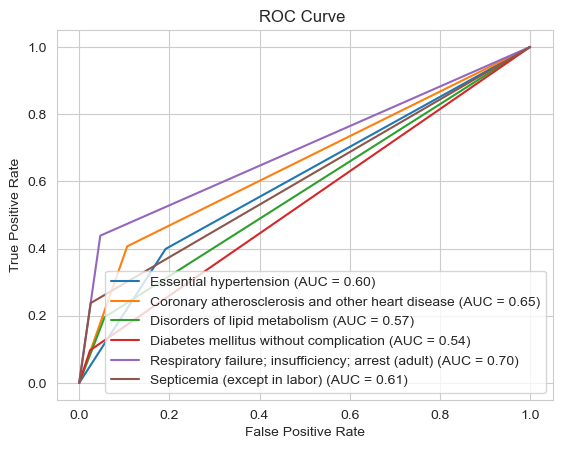

In [129]:
disease_names = [
    "Essential hypertension",
    "Coronary atherosclerosis and other heart disease",
    "Disorders of lipid metabolism",
    "Diabetes mellitus without complication",
    "Respiratory failure; insufficiency; arrest (adult)",
    "Septicemia (except in labor)"
]
auc_values = []
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc, confusion_matrix

roc_auc_micro = roc_auc_score(test_label, y_test_pred, average="micro")
roc_auc_macro = roc_auc_score(test_label, y_test_pred, average="macro")
print(f"Micro-average ROC AUC: {micro_roc_auc}")
print(f"Macro-average ROC AUC: {macro_roc_auc}")

# Classification report
y_pred_binary = np.where(y_test_pred > 0.5, 1, 0)  # Convert probabilities to binary outputs
print(classification_report(test_label, y_pred_binary, target_names=disease_names))

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
test_label_arr = np.array(test_label)
for i in range(6):  # Assuming 6 classes
    fpr[i], tpr[i], _ = roc_curve(test_label_arr[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{disease_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.title(f'ROC Curve ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
auc_values.append([roc_auc[i] for i in range(6)])


In [130]:
auc_values

[[0.6035845689797702,
  0.6500056130993702,
  0.5696432048917345,
  0.5364877582530696,
  0.6957676618725703,
  0.6060935468527033]]

In [131]:
auc_values_models = [[0.6035845689797702,
  0.6500056130993702,
  0.5696432048917345,
  0.5364877582530696,
  0.6957676618725703,
  0.6060935468527033],
 [0.68, 0.82, 0.73, 0.65, 0.83, 0.76],
 [0.6802430956256165,
  0.8138313068899077,
  0.7365300331797384,
  0.6452804940813175,
  0.8548468193047545,
  0.7746647640188152],
 [0.5639224265778016,
  0.649940718797468,
  0.6394398688508082,
  0.5449253731343284,
  0.779739182815767,
  0.6922574916759157],
 [0.6776576679868497,
  0.7917641513108306,
  0.7305374781967184,
  0.6483014320842422,
  0.7956689479392813,
  0.745316209502669]]

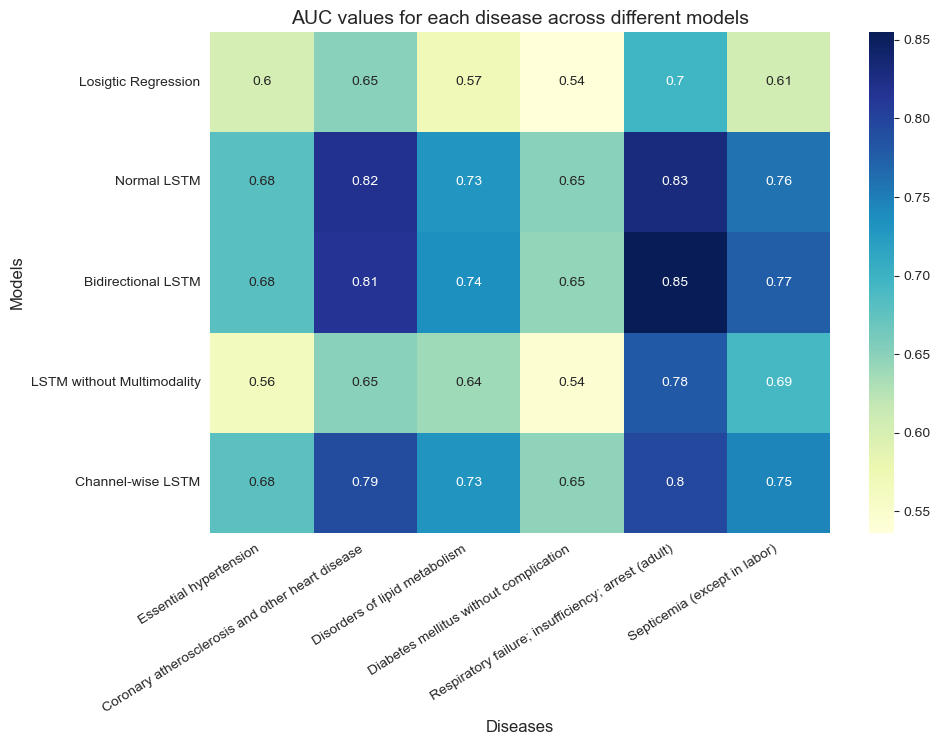

In [141]:
model_names = ["Losigtic Regression","Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]
plt.figure(figsize=(10, 6.5))
sns.heatmap(auc_values_models, annot=True, cmap="YlGnBu", cbar=True, xticklabels=disease_names, yticklabels=model_names)
plt.title('AUC values for each disease across different models', fontsize=14)
plt.xticks(fontsize=10, rotation=32, ha='right')
plt.xlabel('Diseases', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()

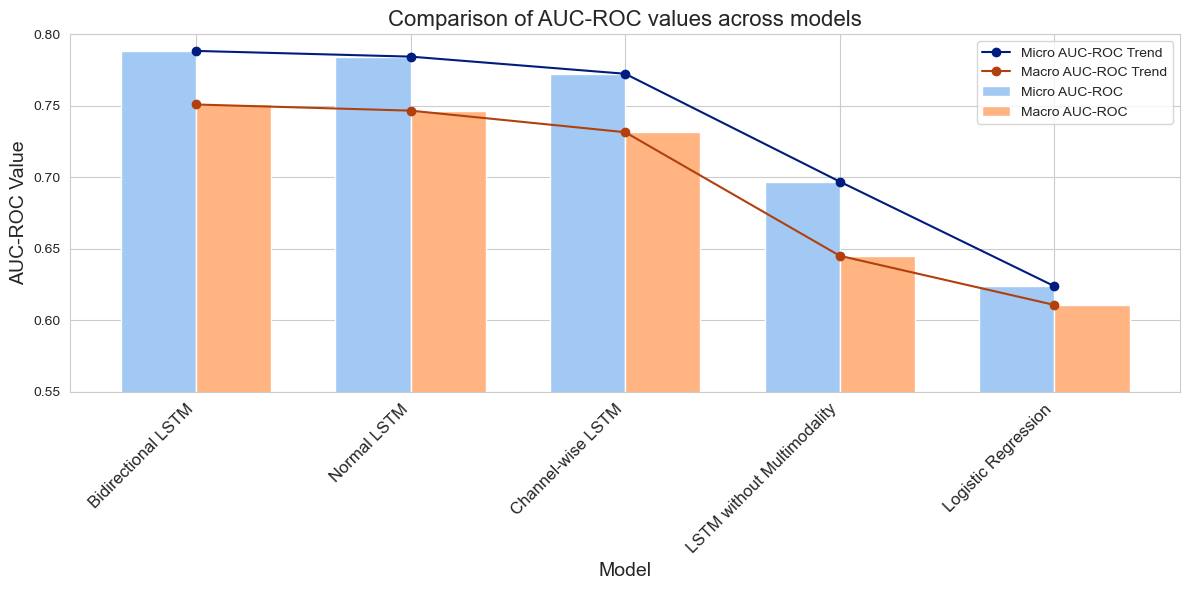

In [151]:
# Model names and AUC-ROC values
model_names = ["Logistic Regression","Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]
micro_auc_values = [0.6237,0.7844, 0.7884, 0.6969, 0.7724]
macro_auc_values = [0.6106,0.7466, 0.7509, 0.6450, 0.7315]
# Combine the data and sort by Micro AUC-ROC values
data = list(zip(model_names, micro_auc_values, macro_auc_values))
data.sort(key=lambda x: x[1], reverse=True)  # Sort by Micro AUC-ROC
sorted_model_names, sorted_micro_auc, sorted_macro_auc = zip(*data)

# Set up the bar positions
bar_width = 0.35
index = np.arange(len(sorted_model_names))

# Create the bars
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Bars for Micro AUC-ROC
bar1 = plt.bar(index - bar_width/2, sorted_micro_auc, bar_width, color=sns.color_palette("pastel")[0], label='Micro AUC-ROC')

# Bars for Macro AUC-ROC
bar2 = plt.bar(index + bar_width/2, sorted_macro_auc, bar_width, color=sns.color_palette("pastel")[1], label='Macro AUC-ROC')

# Overlaying line chart
plt.plot(index, sorted_micro_auc, color=sns.color_palette("dark")[0], marker='o', label='Micro AUC-ROC Trend')
plt.plot(index, sorted_macro_auc, color=sns.color_palette("dark")[1], marker='o', label='Macro AUC-ROC Trend')

# Label the chart
plt.xlabel('Model', fontsize=14)
plt.ylabel('AUC-ROC Value', fontsize=14)
plt.title('Comparison of AUC-ROC values across models', fontsize=16)
plt.xticks(index, sorted_model_names, rotation=45, ha='right', fontsize=12)
plt.ylim(0.55, 0.8)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()

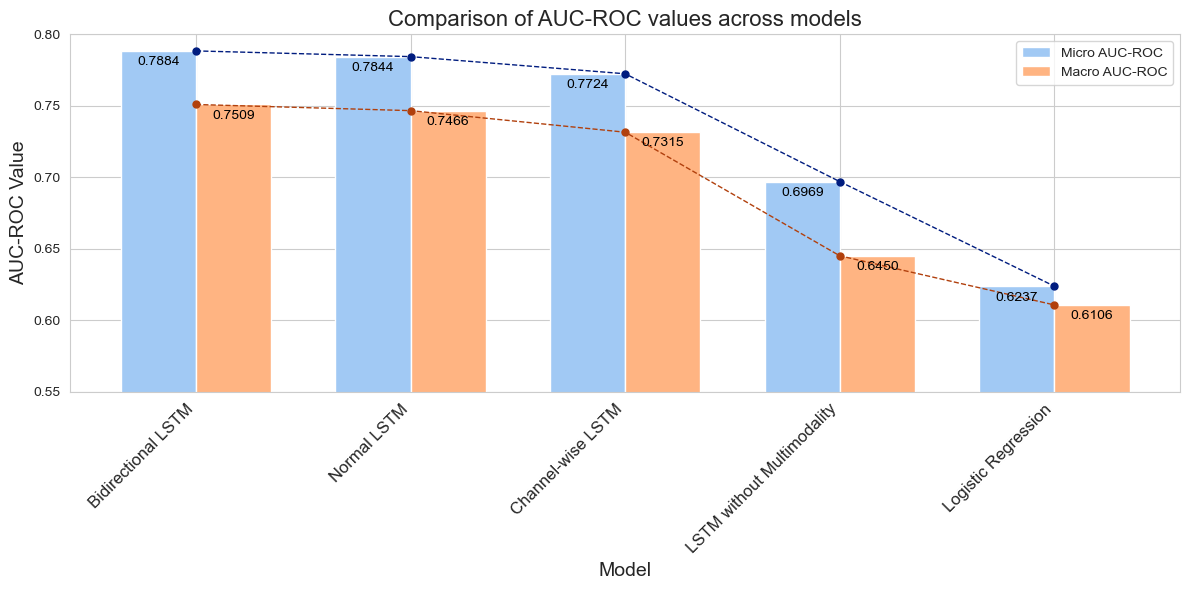

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Model names and AUC-ROC values
model_names = ["Logistic Regression","Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]
micro_auc_values = [0.6237, 0.7844, 0.7884, 0.6969, 0.7724]
macro_auc_values = [0.6106, 0.7466, 0.7509, 0.6450, 0.7315]

# Combine the data and sort by Micro AUC-ROC values
data = list(zip(model_names, micro_auc_values, macro_auc_values))
data.sort(key=lambda x: x[1], reverse=True)
sorted_model_names, sorted_micro_auc, sorted_macro_auc = zip(*data)

# Set up the bar positions
bar_width = 0.35
index = np.arange(len(sorted_model_names))

# Create the bars
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Bars for Micro AUC-ROC
bar1 = plt.bar(index - bar_width/2, sorted_micro_auc, bar_width, color=sns.color_palette("pastel")[0], label='Micro AUC-ROC')

# Bars for Macro AUC-ROC
bar2 = plt.bar(index + bar_width/2, sorted_macro_auc, bar_width, color=sns.color_palette("pastel")[1], label='Macro AUC-ROC')

# Annotate the bars with the values
for i, v in enumerate(sorted_micro_auc):
    plt.text(i - bar_width/2, v - 0.01, "{:.4f}".format(v), color='black', ha='center')

for i, v in enumerate(sorted_macro_auc):
    plt.text(i + bar_width/2, v - 0.01, "{:.4f}".format(v), color='black', ha='center')

# Overlaying line chart
plt.plot(index, sorted_micro_auc, color=sns.color_palette("dark")[0], marker='o', linestyle='dashed', linewidth=1, markersize=5)
plt.plot(index, sorted_macro_auc, color=sns.color_palette("dark")[1], marker='o', linestyle='dashed', linewidth=1, markersize=5)

# Label the chart
plt.xlabel('Model', fontsize=14)
plt.ylabel('AUC-ROC Value', fontsize=14)
plt.title('Comparison of AUC-ROC values across models', fontsize=16)
plt.xticks(index, sorted_model_names, rotation=45, ha='right', fontsize=12)
plt.ylim(0.55, 0.8)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


In [48]:
rf = RandomForestClassifier()
rf.fit(X_train, train_labels)

RandomForestClassifier()

In [49]:
y_pred_r = rf.predict(X_test)

In [50]:
test_roc_auc_rf = roc_auc_score(test_labels, y_pred_r)

In [51]:
print(test_roc_auc_rf)

0.56648803985097


In [52]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020A9236F3A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020A923519A0>})

In [53]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 226}


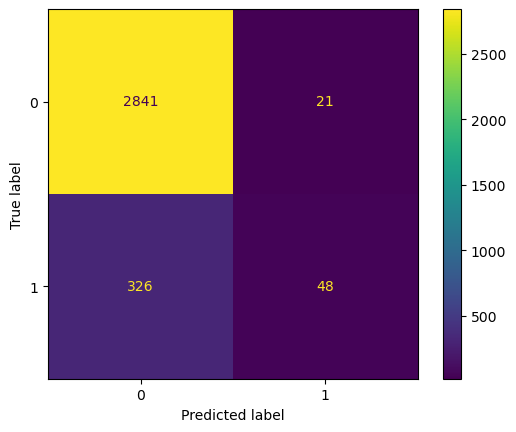

In [54]:
y_pred_cv = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred_cv)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [55]:
test_roc_auc_cv = roc_auc_score(test_labels, y_pred_cv)

In [56]:
print(test_roc_auc_cv)

0.5605023598919271


In [203]:
all_features, label = extract_features_from_reader(train_reader, 0,'train')

In [204]:
len(all_features)

517

In [205]:
all_features

array([ 7.62142857e+01,  1.55690984e+01,  3.40000000e+01,  9.80000000e+01,
       -1.26809674e+00,  3.10000000e+01,  7.07500000e+01,  8.60000000e+01,
        1.52500000e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.10000000e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.50000000e+01,  0.00000000e+00,
        1.50000000e+01,  1.50000000e+01,  0.00000000e+00,  3.10000000e+01,
        1.50000000e+01,  1.50000000e+01,  0.00000000e+00,  3.94000000e+02,
        7.21248917e+01,  3.43000000e+02,  4.45000000e+02,  0.00000000e+00,
        3.10000000e+01,  3.68500000e+02,  4.19500000e+02,  5.10000000e+01,
        1.31500000e+02,  1.09865237e+01,  1.03000000e+02,  1.50000000e+02,
       -5.11255331e-01,  3.10000000e+01,  1.25250000e+02,  1.39000000e+02,
        1.37500000e+01,  9.09404392e+01,  1.70404881e+01,  4.33333015e+01,
        1.11000000e+02, -1.34440588e+00,  3.10000000e+01,  8.49166756e+01,
        1.01333000e+02,  

In [178]:
label

[1]

In [185]:
total_features = []
train_labels = []
for i in range(train_reader.get_number_of_examples()):
    all_features, label = extract_features_from_reader(train_reader, i,'train')
    total_features.append(all_features)
    train_labels.append(label)

In [208]:
from sklearn.preprocessing import StandardScaler
import numpy as np
X = np.array(total_features)
# Define the indices of the categorical features
categorical_indices = list(range(495, 511)) + list(range(512, 518))

# Define the indices of the numerical features
numerical_indices = [i for i in range(X.shape[1]) if i not in categorical_indices]

# Extract the numerical features
X_numerical = X[:, numerical_indices]

# Normalize the numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(X_numerical)

# Put the normalized features back into the original array
X[:, numerical_indices] = X_numerical


In [211]:
X[0]

array([ 1.22152336e+00,  1.17780468e+00, -1.14530508e+00,  1.21141541e+00,
       -1.36742689e+00,  2.06641449e+00,  1.19984592e+00,  1.46425324e+00,
        7.79002235e-01, -4.94761658e-01, -3.27982535e-01, -4.83838510e-01,
       -4.87630583e-01, -1.56549384e-01,  2.06641449e+00, -4.88999613e-01,
       -4.91718271e-01, -3.05940340e-01,  1.29800733e+00, -3.68092336e-01,
        1.35564950e+00,  1.22663020e+00,  3.23126479e-02,  2.06641449e+00,
        1.32495878e+00,  1.26193882e+00, -3.03203217e-01,  2.87298087e+00,
        1.31220108e+00,  2.65268973e+00,  2.11312305e+00, -7.18865824e-02,
        2.06641449e+00,  2.83110339e+00,  3.04819383e+00,  1.84571091e+00,
        2.29274292e+00,  7.47633324e-01,  1.29020979e+00,  2.29295634e+00,
       -6.51008386e-01,  2.06641449e+00,  2.14577202e+00,  2.36357608e+00,
        6.39098445e-01,  9.34476226e-01,  1.11158196e+00, -1.14645791e+00,
        8.19012820e-01, -1.61289961e+00,  2.06641449e+00,  9.48300886e-01,
        1.20242900e+00,  

In [194]:
labels_2d = np.array(train_labels)
labels_1d = labels_2d.reshape(-1)

In [197]:
labels_1d

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [184]:
train_reader.get_number_of_examples()

14681

In [189]:
example = train_reader.read_example(1)

In [191]:
lis = []

lis.append(example['y'])

In [192]:
lis

[0]